<h1>Readability metrics</h1>

The purpose of this notebook is to study the correlation between readability metrics available in the Python package <a href='https://pypi.org/project/py-readability-metrics/#flesch-kincaid-grade-level'>py-readability-metrics</a> and the target of the competition. To install the package, follow instructions in the package site.

In [1]:
# Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from readability import Readability

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

from collections import Counter
import re

import shap

In [2]:
# Constants

INPUT_DIR = '../input'

In [3]:
# Read the data

data = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [4]:
# Create features 

def add_readability_features(text):
    r = Readability(text)
    s = r._statistics
    result = {
        'num_letters': s.num_letters,
        'num_syllables': s.num_syllables,
        'num_words': s.num_words,
        'num_sentences': s.num_sentences,
        'num_poly_syllable_words': s.num_poly_syllable_words,
        'avg_words_per_sentence': s.avg_words_per_sentence,
        'avg_syllables_per_word': s.avg_syllables_per_word,
        'num_dale_chall_complex': s.num_dale_chall_complex,
        'num_gunning_complex': s.num_gunning_complex,
        'num_spache_complex': s.num_spache_complex,
        'flesch_kincaid': r.flesch_kincaid().score,
        'flesch': r.flesch().score,
        'gunning_fog': r.gunning_fog().score,
        'coleman_liau': r.coleman_liau().score,
        'dale_chall': r.dale_chall().score,
        'ari': r.ari().score,
        'linsear_write': r.linsear_write().score,
        'spache': r.spache().score
    }
    return pd.Series(result)
    

metrics = data.excerpt.progress_apply(add_readability_features)

In [5]:
# Feature average word frequency (in the corpus)

def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)   # remove puntuation
    text = text.lower()
    return text.split()

corpus = [preprocess(excerpt) for excerpt in data.excerpt]

counter = Counter()
for excerpt in corpus:
    counter.update(excerpt)
    
def counter_to_relative(counter):
    total_count = sum(counter.values())
    relative = {}
    for key in counter:
        relative[key] = counter[key] / total_count
    return relative

relative = counter_to_relative(counter)

word_frequencies = [[relative[word] for word in excerpt] for excerpt in corpus]

avg_word_frequencies = [np.mean(excerpt) for excerpt in word_frequencies]

#metrics['avg_word_frequency'] = avg_word_frequencies


# Frequency features

with open(os.path.join(INPUT_DIR, '500.txt'), 'r') as f:
    most_common_500 = set(f.read().split('\n'))

with open(os.path.join(INPUT_DIR, '1000.txt'), 'r') as f:
    most_common_1000 = set(f.read().split('\n'))

with open(os.path.join(INPUT_DIR, '3000.txt'), 'r') as f:
    most_common_3000 = set(f.read().split('\n'))

with open(os.path.join(INPUT_DIR, '5000.txt'), 'r') as f:
    most_common_5000 = set(f.read().split('\n'))

with open(os.path.join(INPUT_DIR, '10000.txt'), 'r') as f:
    most_common_10000 = set(f.read().split('\n'))

    
def add_frequency_features(text):
    text_words = set(preprocess(text))
    in_500 = [w for w in text_words if w in most_common_500]
    in_1000 = [w for w in text_words if w in most_common_1000]
    in_3000 = [w for w in text_words if w in most_common_3000]
    in_5000 = [w for w in text_words if w in most_common_5000]
    in_10000 = [w for w in text_words if w in most_common_10000]

    result = {
        'in_500': len(in_500) / len(text_words),
        'in_1000': len(in_1000) / len(text_words),
        'in_3000': len(in_3000) / len(text_words),
        'in_5000': len(in_5000) / len(text_words),
        'in_10000': len(in_10000) / len(text_words)
    }
    return pd.Series(result)
    
frequency_features = data.excerpt.progress_apply(add_frequency_features)

In [6]:
all_features = pd.concat([metrics, frequency_features], axis=1)
all_features.head()

,num_letters,num_syllables,num_words,num_sentences,num_poly_syllable_words,avg_words_per_sentence,avg_syllables_per_word,num_dale_chall_complex,num_gunning_complex,num_spache_complex,...,coleman_liau,dale_chall,ari,linsear_write,spache,in_500,in_1000,in_3000,in_5000,in_10000
0,789.0,245.0,179.0,11.0,16.0,16.272727,1.368715,24.0,16.0,36.0,...,8.298994,6.560722,7.467202,8.590909,4.863063,0.355769,0.490385,0.557692,0.615385,0.807692
1,730.0,251.0,183.0,15.0,12.0,12.200000,1.371585,39.0,12.0,52.0,...,5.229508,7.606702,3.458525,5.900000,5.002916,0.454545,0.590909,0.663636,0.718182,0.800000
2,712.0,238.0,176.0,11.0,15.0,16.000000,1.352273,41.0,14.0,55.0,...,6.137273,8.108452,5.624091,8.363636,5.782500,0.439655,0.594828,0.655172,0.655172,0.844828
3,716.0,215.0,164.0,5.0,7.0,32.800000,1.310976,18.0,4.0,46.0,...,8.968780,6.996429,15.533171,17.800000,7.875995,0.348624,0.504587,0.522936,0.587156,0.733945
4,549.0,175.0,147.0,5.0,5.0,29.400000,1.190476,5.0,1.0,13.0,...,5.153197,1.995315,10.860408,15.700000,5.744944,0.595238,0.833333,0.809524,0.809524,0.928571


<AxesSubplot:>

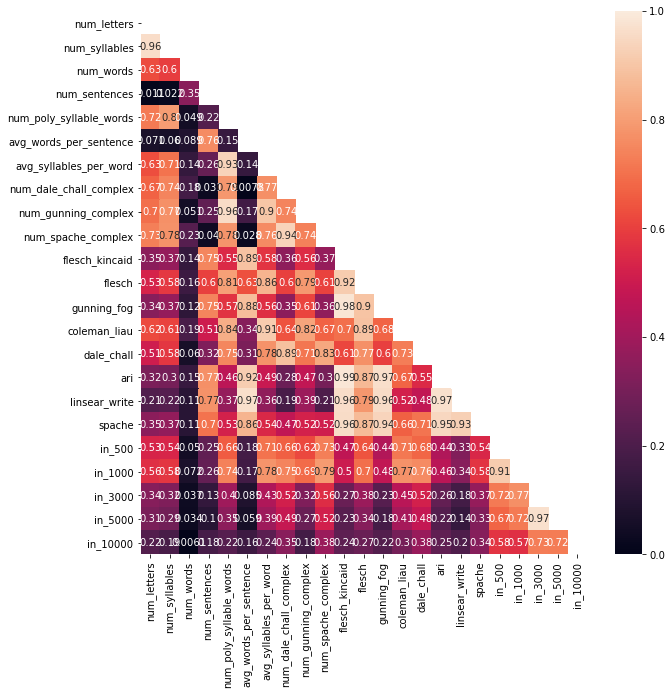

In [7]:
# Show correlations among features

fig = plt.figure(figsize=(10,10))
corr = all_features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(np.abs(corr), mask=mask, vmin=0, vmax=1, annot=True)

<h2>Quick and dirty random forest model based on the readability metrics</h2>

In [8]:
x = all_features.values
y = data['target'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

In [9]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['root_mean_squared_error'],
    'learning_rate': 0.005,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 3,
    "num_leaves": 64,  
    "max_bin": 256,
    "num_iterations": 100000,
    "n_estimators": 2000
}

In [10]:
%%time

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(x_train, y_train,
        eval_set=[(x_val, y_val)],
        early_stopping_rounds=1000)

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [W

[880]	valid_0's rmse: 0.748523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 0.748465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 0.748452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 0.748477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 0.748467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid_0's rmse: 0.748431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 0.748384
[887]	valid_0's rmse: 0.748422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's rmse: 0.748401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's rmse: 0.748356
[890]	valid_0's rmse: 0.748335
[LightGBM] [Warning] No further splits with positive gain, 

[1799]	valid_0's rmse: 0.742835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	valid_0's rmse: 0.742816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1801]	valid_0's rmse: 0.742795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1802]	valid_0's rmse: 0.742785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1803]	valid_0's rmse: 0.742764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1804]	valid_0's rmse: 0.742736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1805]	valid_0's rmse: 0.742727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1806]	valid_0's rmse: 0.742733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1807]	valid_0's rmse: 0.742718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1808]	valid_0's rmse: 0.742702
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2754]	valid_0's rmse: 0.743608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2755]	valid_0's rmse: 0.743643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2756]	valid_0's rmse: 0.743632
[2757]	valid_0's rmse: 0.743652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2758]	valid_0's rmse: 0.743639
[2759]	valid_0's rmse: 0.743657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2760]	valid_0's rmse: 0.743645
[2761]	valid_0's rmse: 0.743642
[2762]	valid_0's rmse: 0.743632
[2763]	valid_0's rmse: 0.743617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2764]	valid_0's rmse: 0.743617
[2765]	valid_0's rmse: 0.743629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2766]	valid_0's rmse: 0.743631
[2767]	valid_0's rmse: 0.743636
[2768]	valid_0's rmse: 0.74

LGBMRegressor(bagging_fraction=0.5, bagging_freq=5, feature_fraction=0.7,
              learning_rate=0.005, max_bin=256, max_depth=3,
              metric=['root_mean_squared_error'], n_estimators=2000,
              num_iterations=100000, num_leaves=64, objective='regression',
              task='train', verbose=0)

In [11]:
y_val_pred = gbm.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f'rmse = {np.sqrt(mse)}')

rmse = 0.7423050378797617


<h2>Feature importance</h2>

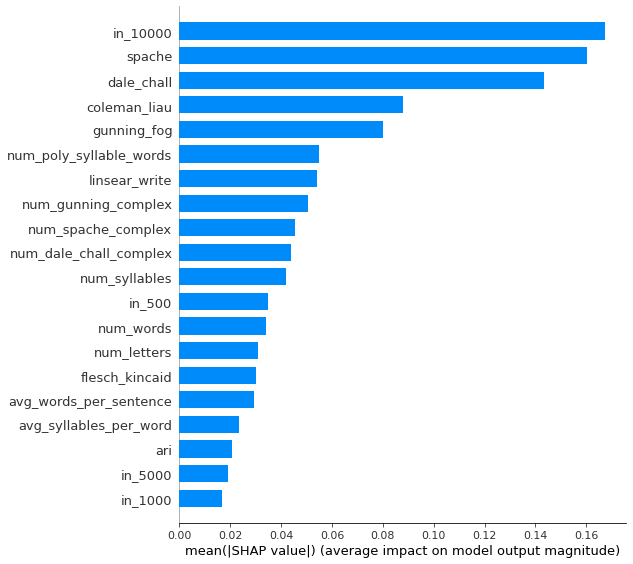

CPU times: user 8.42 s, sys: 119 ms, total: 8.54 s
Wall time: 667 ms


In [12]:
%%time

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(x, check_additivity=False)
shap.summary_plot(shap_values, x, feature_names=all_features.columns, plot_type="bar")